In [1]:
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import ultraplot as uplt

# Statsmodels imports
import statsmodels.formula.api as sm
from statsmodels.stats.multitest import fdrcorrection

In [9]:
def prepare_data(prcp_filepath, tmax_filepath, landcover_filepath, area_filepath):
    prcp = pd.read_csv(prcp_filepath)
    tmax = pd.read_csv(tmax_filepath)
    landcover = pd.read_csv(landcover_filepath)
    area = pd.read_csv(area_filepath)

    dest_crs = ccrs.LambertConformal(central_longitude=-76.0, central_latitude=42.0,)
    county = gpd.read_file('./Data/counties_2021.geojson')
    county = county.to_crs(dest_crs)[['ADM2_NAME', 'geometry']]

    combined = gpd.GeoDataFrame(pd.concat([prcp, tmax, landcover, area, county], axis=1))
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    combined['total_forest'] = combined['deciduous'] + combined['evergreen'] + combined['mixed']
    combined['perc_deciduous'] = combined['deciduous']/combined['total_forest']
    combined['perc_evergreen'] = combined['evergreen']/combined['total_forest']
    combined['perc_mixed'] = combined['mixed']/combined['total_forest']
    combined['perc_defol_area'] = combined['sum']/combined['count']
    
    def standardize(x):
        return (x - x.mean()) / x.std()

    factors = ({'total':'z_prcp_total', 'anom':'z_prcp_anom'} 
               | {factor:f'z_{factor}' 
                  for factor in 
                      ['tmax_mean', 'tmax_anom', 'perc_deciduous', 'perc_evergreen', 'perc_mixed', 'perc_defol_area']})

    for factor in factors:
        combined[factors[factor]] = standardize(combined[factor])

    
    return combined

In [19]:
def partial_regression(ax, data, x_residual, x_initial, y, xlabel, mls_pvalue, ms=10, ls='dashed'):
    # Compute x residuals
    formula = x_residual + ' ~ ' + ' + '.join(x_initial)
    x_reg = sm.ols(formula=formula, data=data).fit()

    predicted = x_reg.params['Intercept']
    for x in x_initial:
        predicted += x_reg.params[x]*data[x]
    data['x_residuals'] = data[x_residual] - predicted
    
    # Compute y residuals
    formula = y + ' ~ ' + ' + '.join(x_initial)
    y_reg = sm.ols(formula=formula, data=data).fit()
    
    predicted = y_reg.params['Intercept']
    for x in x_initial:
        predicted += y_reg.params[x]*data[x]
    data['y_residuals'] = data[y] - predicted
    
    # Compute partial regression
    res_reg = sm.ols('y_residuals ~ x_residuals', data=data).fit()

    # Plot residuals
    ax.scatter(data['x_residuals'], data['y_residuals'], color='gray', markersize=ms)

    x = np.array(ax.get_xlim())
    y_pred = res_reg.params['Intercept'] + res_reg.params['x_residuals']*x

    print(res_reg.params['x_residuals'])

    # Plot partial regression
    ax.plot(x, y_pred, color='black', linestyle=ls)
    ax.format(xlabel=xlabel, ylabel='Residuals',
              upperrighttitle=f'slope={res_reg.params['x_residuals']:.4f}\np={mls_pvalue:.4f}')

In [12]:
defol_2021 = prepare_data('./Data/Enviro/prcp_twelve_month_county_2021.csv', 
                          './Data/Enviro/tmax_twelve_month_county_2021.csv', 
                          './Data/Enviro/landcover_distribution.csv', 
                          './Data/Enviro/defol_area_county_2021.csv')

In [13]:
defol_2022 = prepare_data('./Data/Enviro/prcp_twelve_month_county_2022.csv', 
                          './Data/Enviro/tmax_twelve_month_county_2022.csv', 
                          './Data/Enviro/landcover_distribution.csv', 
                          './Data/Enviro/defol_area_county_2022.csv')

## Method 1: 2021 as predictor for 2022

In [14]:
# Add defol in 2021 
defol_2022['perc_defol_area_2021'] = defol_2021['perc_defol_area']

In [16]:
mod = sm.ols(formula='perc_defol_area ~  z_prcp_anom + z_tmax_anom + perc_defol_area_2021', data=defol_2022)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        perc_defol_area   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     11.37
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           5.77e-06
Time:                        10:22:26   Log-Likelihood:                 172.02
No. Observations:                  62   AIC:                            -336.0
Df Residuals:                      58   BIC:                            -327.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0076 

0.0022051699620012615
-0.005181255683206555
0.22071473923990606


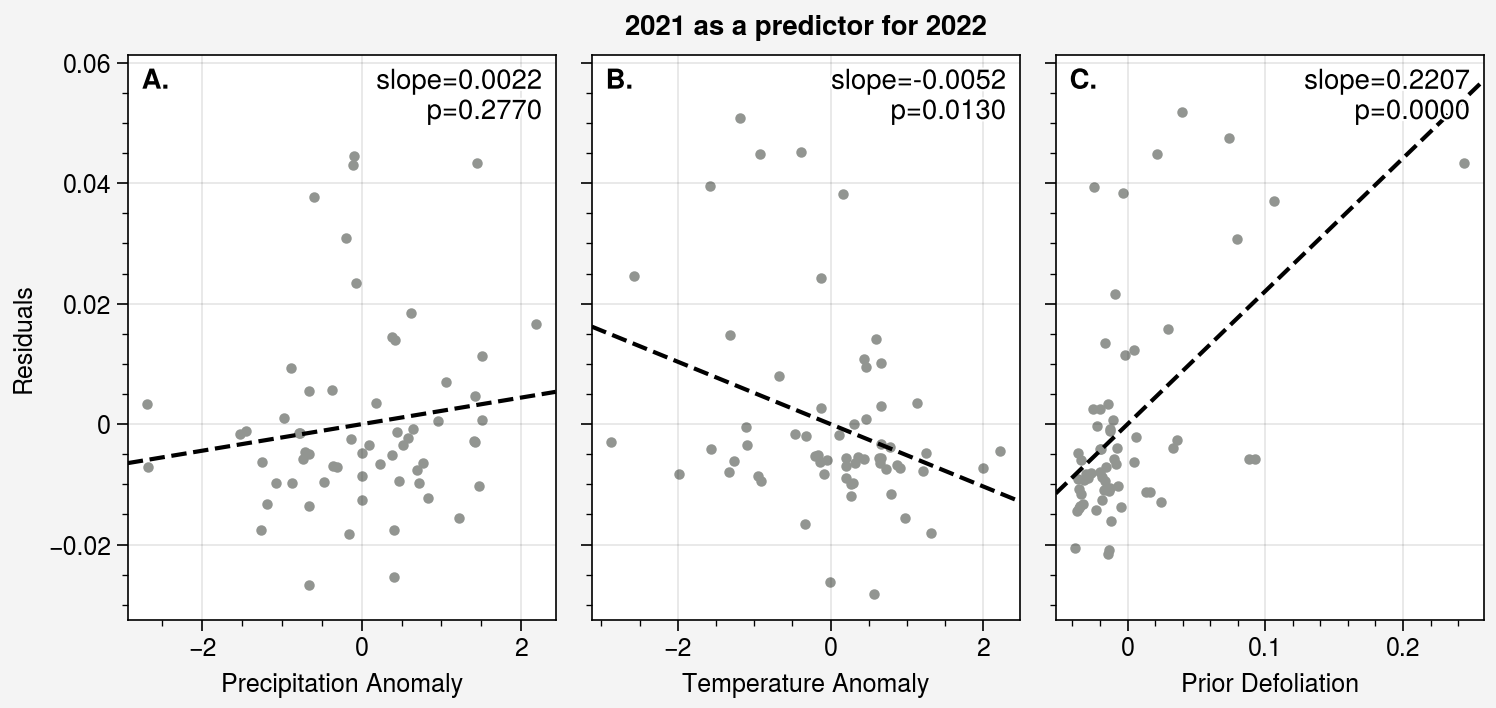

In [23]:
# Partial regressions
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')
fig.format(suptitle='2021 as a predictor for 2022')

partial_regression(axes[0], defol_2022, 'z_prcp_anom', ['z_tmax_anom', 'perc_defol_area_2021'], 'perc_defol_area', 'Precipitation Anomaly', 0.277)
partial_regression(axes[1], defol_2022, 'z_tmax_anom', ['z_prcp_anom', 'perc_defol_area_2021'], 'perc_defol_area', 'Temperature Anomaly', 0.013)
partial_regression(axes[2], defol_2022, 'perc_defol_area_2021', ['z_prcp_anom', 'z_tmax_anom'], 'perc_defol_area', 'Prior Defoliation', 0.000)

## Method 2: Predict change between 2021 and 2022

In [24]:
# Add defol in 2021 
defol_2022['defol_change'] = defol_2022['perc_defol_area'] - defol_2021['perc_defol_area']

In [25]:
mod = sm.ols(formula='defol_change ~  z_prcp_anom + z_tmax_anom', data=defol_2022)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           defol_change   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.020
Method:                 Least Squares   F-statistic:                    0.3921
Date:                Tue, 29 Apr 2025   Prob (F-statistic):              0.677
Time:                        10:29:27   Log-Likelihood:                 113.83
No. Observations:                  62   AIC:                            -221.7
Df Residuals:                      59   BIC:                            -215.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0209      0.005     -4.151      

0.0030890644370907615
-0.003582180577880863


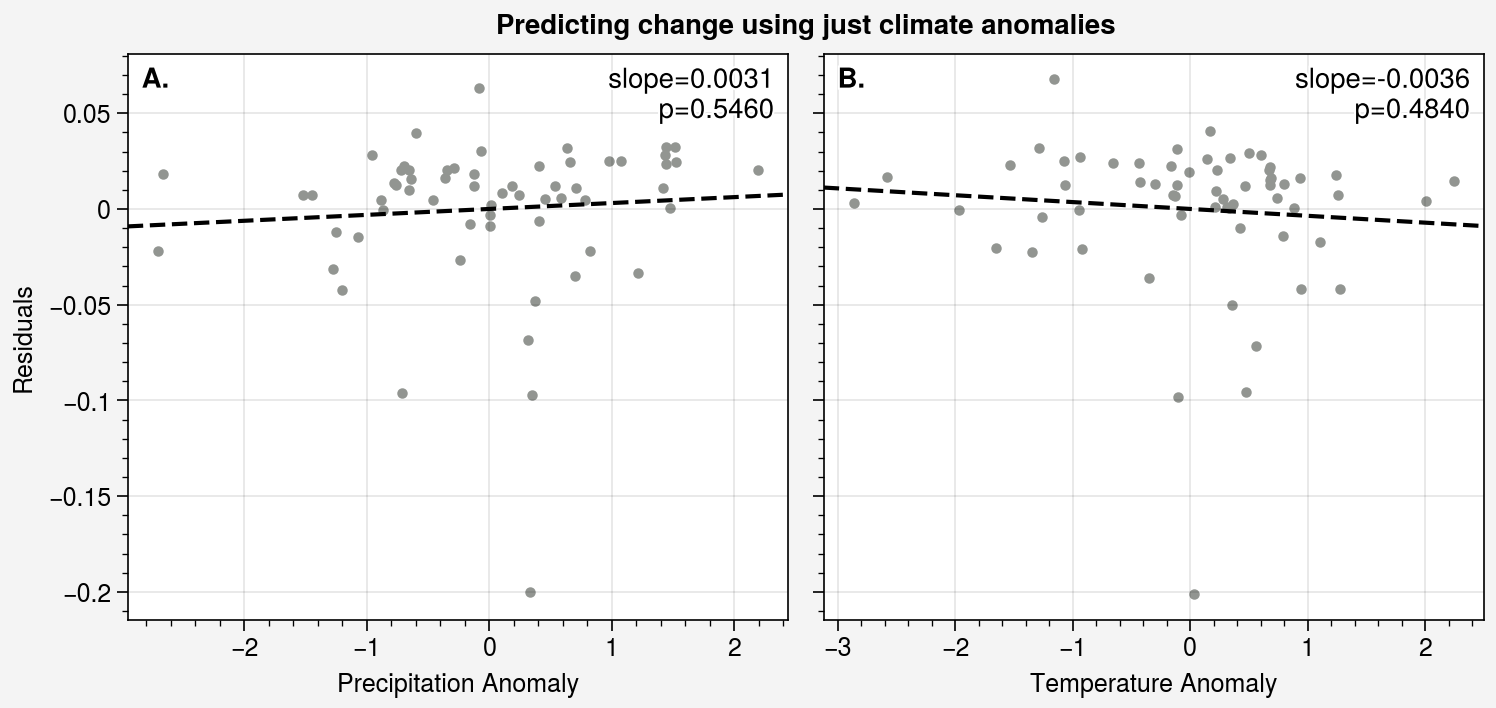

In [28]:
fig, axes = uplt.subplots(ncols=2, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')
fig.format(suptitle='Predicting change using just climate anomalies')

partial_regression(axes[0], defol_2022, 'z_prcp_anom', ['z_tmax_anom'], 'defol_change', 'Precipitation Anomaly', 0.546)
partial_regression(axes[1], defol_2022, 'z_tmax_anom', ['z_prcp_anom'], 'defol_change', 'Temperature Anomaly', 0.484)

In [31]:
mod = sm.ols(formula='defol_change ~  z_prcp_anom + z_tmax_anom + perc_defol_area_2021', data=defol_2022)

res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           defol_change   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     108.7
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           8.80e-24
Time:                        10:33:02   Log-Likelihood:                 172.02
No. Observations:                  62   AIC:                            -336.0
Df Residuals:                      58   BIC:                            -327.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.0076 

0.002205169962001261
-0.005181255683206555
-0.7792852607600939


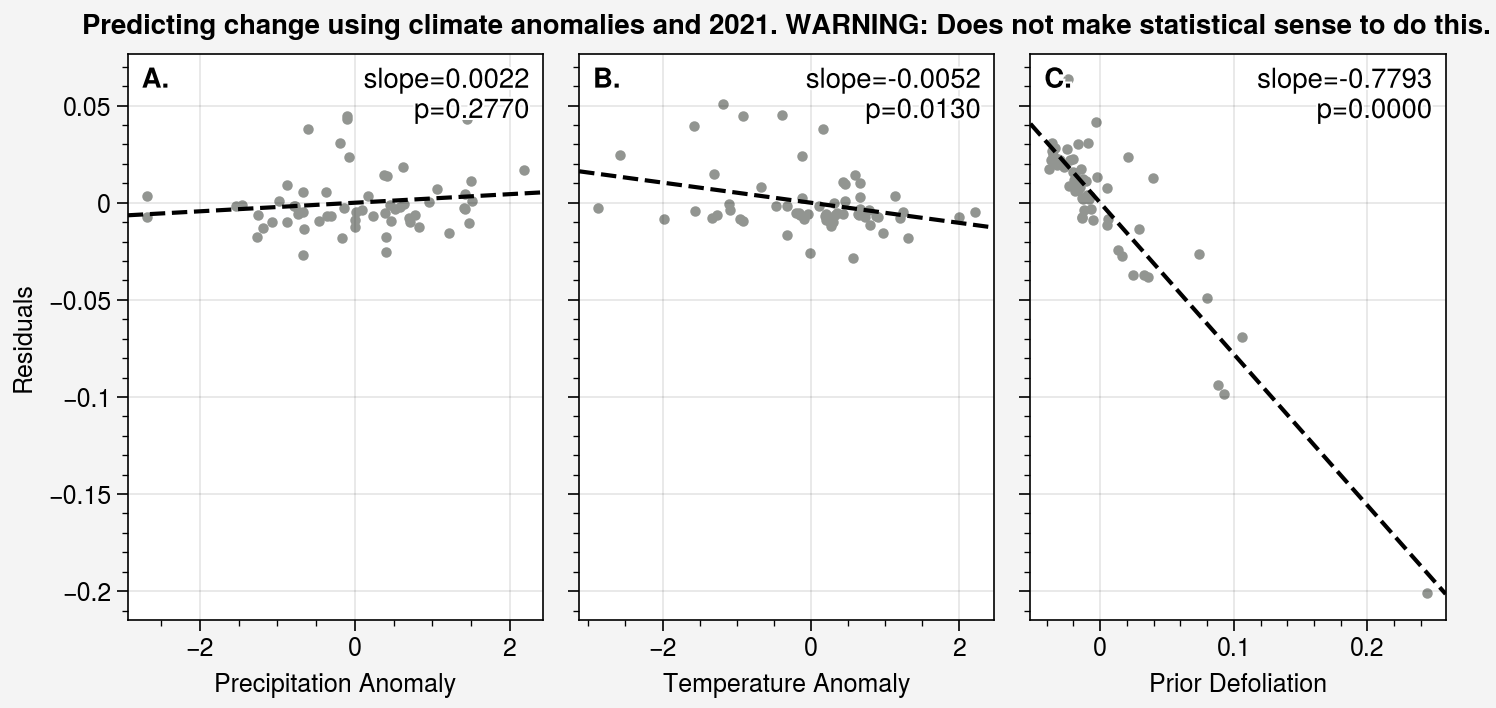

In [33]:
# Partial regressions
fig, axes = uplt.subplots(ncols=3, sharex=False, figsize=("190mm", "90mm"), fontsize=9)

axes.format(abc='A.', abcloc='ul')
fig.format(suptitle='Predicting change using climate anomalies and 2021. WARNING: Does not make statistical sense to do this.')

partial_regression(axes[0], defol_2022, 'z_prcp_anom', ['z_tmax_anom', 'perc_defol_area_2021'], 'defol_change', 'Precipitation Anomaly', 0.277)
partial_regression(axes[1], defol_2022, 'z_tmax_anom', ['z_prcp_anom', 'perc_defol_area_2021'], 'defol_change', 'Temperature Anomaly', 0.013)
partial_regression(axes[2], defol_2022, 'perc_defol_area_2021', ['z_prcp_anom', 'z_tmax_anom'], 'defol_change', 'Prior Defoliation', 0.000)